# Image Style Transfer
<img src="https://github.com/GunhoChoi/PyTorch-FastCampus/raw/1e9ba63e9ccffa28637f9c441d6d5faf35696268/07_Transfer_Learning/1_StyleTransfer/styletransfer_image.png">

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# HyperParameter

In [2]:
content_layer_num = 1
image_size = 256
epoch = 1000

# 1) Directory 

In [3]:
content_dir = './image/content/Neckarfront_origin.jpg'
style_dir = "./image/style/StarryNight.jpg"

# 2) Preprocessing Function

In [4]:
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    print(img)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
                            mean=[0.40760392,
                                  0.45795686, 
                                  0.48501961],
                            std=[1,1,1]),
    ])
    img = transform(img).view((-1, 
                                3,
                                image_size,
                                image_size))
    print(type(img))
    return img

# 3) Postprocessing Function

In [47]:
def image_postprocess(tensor):
      
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],
                              std=[1,1,1]), 
    ])
    print(tensor.size())
    #img = transform(tensor.clone()) # 이걸 쓰면 에러가 난다...
    # tensor is not a torch image. 이어야 한다는데 이건 [1,3,256,256] 형태라 토치 이미지 포멧이 아니라 그런가부다...
    # 이건 해결책이다,
    tensor = tensor.to('cpu')
    img = transform(tensor.clone().view(3, image_size, image_size))
    img = img.clamp(0,1)
    
    return img

# 4) Image Showing Function

In [40]:
def imshow(tensor):
    image = tensor.clone().cpu()
    image = image.view(3, image_size, image_size)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.show()

# 3. Model & Loss Function

## 1) Resnet

In [7]:
resnet = models.resnet50(pretrained=True)
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [8]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])
        
    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        
        return out_0, out_1, out_2, out_3, out_4, out_5

# Gram Matrix Function

In [9]:
# gram matrix 
# [batch, channel, height, width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]
# b만큼의 배치가 동일하게 곱해진다.
# => bmm은 batch multiplication이다.
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2))
        return G

# pre trained라서 학습 시키지 않는다.

In [10]:
resnet = Resnet().cuda()
for param in resnet.parameters():
    param.requires_grad = False

## Gram Matrix Loss

In [49]:
# 타겟과 gramMatrix의 차이의 로스
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

# Train

In [12]:
content = image_preprocess(content_dir).requires_grad_(False).cuda()
style = image_preprocess(style_dir).requires_grad_(False).cuda()
generated = content.data.clone().requires_grad_(True)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2715CFFC4E0>
<class 'torch.Tensor'>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=970x768 at 0x2715CFFC438>
<class 'torch.Tensor'>


In [13]:
type(image_preprocess(content_dir))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2710004CB38>
<class 'torch.Tensor'>


torch.Tensor

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x27100056CC0>
<class 'torch.Tensor'>
torch.Size([1, 3, 256, 256])


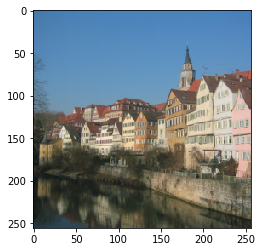

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=970x768 at 0x271000BBF98>
<class 'torch.Tensor'>
torch.Size([1, 3, 256, 256])


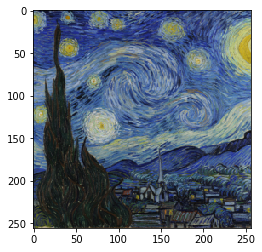

In [14]:
imshow(image_postprocess(image_preprocess(content_dir)))
imshow(image_postprocess(image_preprocess(style_dir)))

In [15]:
style_target = list(GramMatrix().cuda()(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

In [16]:
# resnet(style) => out0에서 out5까지 리턴하는데 이걸 각각 GramMaxtirx에 넣는다.

In [17]:
# print(content_layer_num)
# resnet(content)[content_layer_num]
print(generated.size())

torch.Size([1, 3, 256, 256])


In [18]:

optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        style_loss = [GramMSELoss().cuda()(out[i], style_target[i])
                      *style_weight[i] for i in range(len(style_target))]
        content_loss = nn.MSELoss().cuda()(
                                    out[content_layer_num],
                                    content_target)
        
        # style loss를 만든다. 그것은 style_weight를 곱하고 다 더한것이다.
        total_loss = 1000 * torch.sum(style_loss[0])
        for i in range(1,len(style_loss)):
            total_loss +=1000 * torch.sum(style_loss[i]) 
        
        total_loss +=  torch.sum(content_loss)
        # 최종로스는 모두 더한 것
        total_loss.backward() 
        # 이걸 backprob
        
        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        
        return total_loss
    
    optimizer.step(closure)

tensor(89934.0078, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(4.4782, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.9064, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.3855, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.2356, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.1772, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.1469, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.1295, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.1172, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(0.1086, device='cuda:0', grad_fn=<ThAddBackward>)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x271001066A0>
<class 'torch.Tensor'>
torch.Size([1, 3, 256, 256])


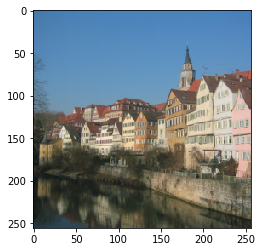

In [21]:
imshow(image_postprocess(image_preprocess(content_dir)))


torch.Size([1, 3, 256, 256])


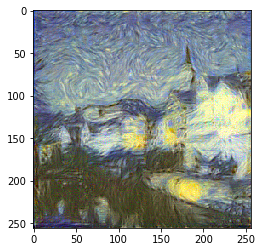

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=970x768 at 0x2711B311BE0>
<class 'torch.Tensor'>
torch.Size([1, 3, 256, 256])


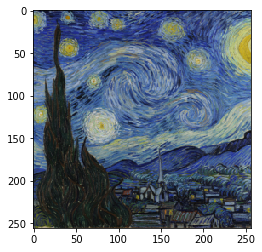

In [48]:
imshow(image_postprocess(generated.data))
imshow(image_postprocess(image_preprocess(style_dir)))